### Your name:

<pre> Cindy Lopes </pre>

### Collaborators:

<pre> </pre>


# Assignment for Module 4: Clustering

## Description

In this assignment you will study the electric demand (power) of clients in Portugal, during 2013 and 2014.

The data$^1$ available contains 370 time series, corresponding to the electric demand$^2$ for 370 clients, between 2011 and 2014. 

In this guided exercise you will use clustering techniques to understand the typical behaviour during 2013-2014.

#### 1. Data:
https://archive.ics.uci.edu/ml/datasets/ElectricityLoadDiagrams20112014#

#### 2. Electric Demand:
http://www.think-energy.net/KWvsKWH.htm


## Data Preparation

Start by downloading the data to a local directory and modify the "pathToFile" and "fileName" variables, if needed

In [1]:
pathToFile = r"./datasets/"
fileName = 'LD2011_2014.txt'

In [2]:
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import matplotlib.dates as matdates
from matplotlib.colors import ListedColormap
import seaborn as sns
%matplotlib inline

import random
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering
from sklearn.manifold import TSNE, MDS
from sklearn.decomposition import PCA
random.seed(123)

In [3]:
# Replace "," by ".", otherwise the numbers will be in the form 2,3445 instead of 2.3445
import fileinput

with fileinput.FileInput(pathToFile+fileName, inplace=True, backup='.bak') as file:
    for line in file:
        print(line.replace(",", "."), end='')

In [4]:
# Create dataframe
import pandas as pd
data = pd.read_csv(pathToFile+fileName, sep=";", index_col=0)

In [5]:
data.head(2)

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,...,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
2011-01-01 00:15:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-01 00:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Quick data inspection

In [6]:
data.head(2)

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,...,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
2011-01-01 00:15:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-01 00:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
data.tail(2)

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,...,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
2014-12-31 23:45:00,1.269036,21.337127,1.737619,166.666667,85.365854,285.714286,10.17524,225.589226,64.685315,72.043011,...,246.252677,28000.0,1443.037975,909.090909,26.075619,4.095963,664.618086,146.911519,646.627566,6540.540541
2015-01-01 00:00:00,2.538071,19.914651,1.737619,178.861789,84.146341,279.761905,10.17524,249.158249,62.937063,69.892473,...,188.436831,27800.0,1409.282700,954.545455,27.379400,4.095963,628.621598,131.886477,673.020528,7135.135135


In [8]:
data.shape

(140256, 370)

#### As can be seen, the dataframe contains a row for each interval of 15 minutes between Jan 1, 2011 to Dec 31 2014. There are 370 columns corresponding 370 clients. The dataframe is indexed by the timestamp.

Since the frequency is 15 minutes, each day provides $24\times 4 = 96$ datapoints, which multiplied by 365 days and 4 years (plus 1 day in Feb 29, 2012) gives: $96 \times 365 \times 4 + 96 = 140256$, as observed in data.shape

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 140256 entries, 2011-01-01 00:15:00 to 2015-01-01 00:00:00
Columns: 370 entries, MT_001 to MT_370
dtypes: float64(370)
memory usage: 397.0+ MB


In [10]:
data.describe()

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,...,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
count,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,...,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000
mean,3.970785,20.768480,2.918308,82.184490,37.240309,141.227385,4.521338,191.401476,39.975354,42.205152,...,218.213701,37607.987537,1887.427366,2940.031734,65.413150,9.269709,424.262904,94.704717,625.251734,8722.355145
std,5.983965,13.272415,11.014456,58.248392,26.461327,98.439984,6.485684,121.981187,29.814595,33.401251,...,204.833532,38691.954832,1801.486488,2732.251967,65.007818,10.016782,274.337122,80.297301,380.656042,9195.155777
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.844950,0.000000,36.585366,15.853659,71.428571,0.565291,111.111111,13.986014,9.677419,...,5.710207,0.000000,0.000000,0.000000,13.037810,0.000000,0.000000,30.050083,83.944282,0.000000
50%,1.269036,24.893314,1.737619,87.398374,39.024390,157.738095,2.826456,222.222222,40.209790,40.860215,...,131.334761,24100.000000,1050.632911,2136.363636,31.290743,7.021650,525.899912,76.794658,758.064516,0.000000
75%,2.538071,29.871977,1.737619,115.853659,54.878049,205.357143,4.522329,279.461279,57.692308,61.290323,...,403.283369,54800.000000,3312.236287,5363.636364,108.213820,11.702750,627.743635,151.919866,875.366569,17783.783784
max,48.223350,115.220484,151.172893,321.138211,150.000000,535.714286,44.657999,552.188552,157.342657,198.924731,...,852.962170,192800.000000,7751.054852,12386.363636,335.071708,60.269163,1138.718174,362.270451,1549.120235,30918.918919


### Plot the 2 days of 2012 for the first 2 clients

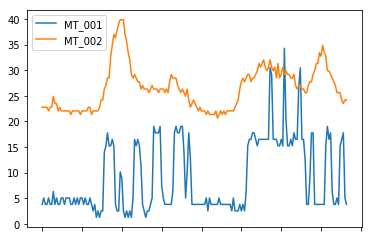

In [11]:
data_example = data.loc['2012-01-01 00:15:00':'2012-01-03 00:00:00'][['MT_001','MT_002']]
data_example.plot()
plt.show()

#### We quickly note that the main difference between the curves is the level (also seen on the means in df.describe()), so we know we will have to somehow normalize the curves, in order for the clustering technique to capture the behaviour of the consumption throughout the day, rather than the overall level.

### Data for the analysis

We focus on 2013 and 2014 because these are the years with lower number of clients having zero demand

In [12]:
data2011 = data.loc['2011-01-01 00:15:00':'2012-01-01 00:00:00']
data2012 = data.loc['2012-01-01 00:15:00':'2013-01-01 00:00:00']
data2013 = data.loc['2013-01-01 00:15:00':'2014-01-01 00:00:00']
data2014 = data.loc['2014-01-01 00:15:00':'2015-01-01 00:00:00']

In [13]:
# Check number of days
print(data2011.shape[0]/96)
print(data2012.shape[0]/96)
print(data2013.shape[0]/96)
print(data2014.shape[0]/96)

365.0
366.0
365.0
365.0


In [14]:
# See number of clients with 0 demand per year
print(sum(data2011.mean()==0))
print(sum(data2012.mean()==0))
print(sum(data2013.mean()==0))
print(sum(data2014.mean()==0))

210
37
21
1


In [15]:
clients = data2011.columns
clients_no_demand = clients[data2013.mean()==0] # clients with 0 demand
data_13_14 = data2013.append(data2014) # appending 2013 and 2014
data_13_14 = data_13_14.drop(clients_no_demand, axis=1) # drop clients with 0 demand
print(data_13_14.shape)
print(sum(data_13_14.mean()==0)) # check that there are no clients with 0 demand

(70080, 349)
0


## Getting average curves per client

In [16]:
data = data_13_14.copy() # weekdays weekends, data2011, data2012, data2013, data2014

In [17]:
data['hour'] = data.index.map(lambda x: x[11:])

In [18]:
data.head(3)

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,...,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370,hour
2013-01-01 00:15:00,2.538071,22.759602,2.606429,138.211382,63.414634,255.952381,4.522329,239.057239,57.692308,78.494624,...,22300.0,886.075949,1000.000000,16.949153,6.436513,616.330114,76.794658,731.671554,8086.486486,00:15:00
2013-01-01 00:30:00,1.269036,22.759602,2.606429,138.211382,63.414634,264.880952,5.652911,228.956229,57.692308,76.344086,...,21000.0,864.978903,909.090909,18.252934,3.510825,564.530290,76.794658,727.272727,8086.486486,00:30:00
2013-01-01 00:45:00,2.538071,22.759602,2.606429,134.146341,60.975610,250.000000,5.652911,239.057239,54.195804,76.344086,...,18200.0,860.759494,840.909091,16.949153,5.851375,590.869183,68.447412,730.205279,7848.648649,00:45:00


### Getting average curves per client

In [19]:
datagrouped = data.groupby("hour")
average_curves = datagrouped.agg("mean")
average_curves.shape 

(96, 349)

#### The dataframe average_curves contains the 349 typical weekday electric demands

#### We now divide each curve by its mean, so that all curves have mean 1

In [20]:
average_curves_norm = average_curves/(average_curves.mean())

#### Plot the first 2 and last 2 clients

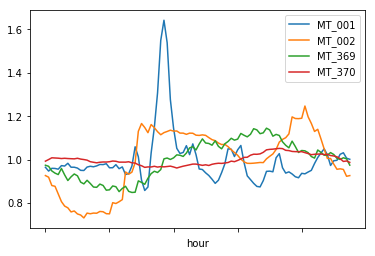

In [21]:
average_curves_norm[['MT_001','MT_002','MT_369','MT_370']].plot()
plt.show()

## Clustering Analysis on the average normizalied curves

In [22]:
X = average_curves_norm.copy()
X = np.array(X.T) # put it on the right format

In [23]:
X.shape

(349, 96)

## Exercise 1:

a. Using the functions described in Module 2, determine what a convenient number of clusters based on _intertia_ and based on _silhouette_. Justify your choice

b. Make a plot for each cluster, that includes:
    - The number of clients in the cluster (you can put this in the title of the plot)
    - All the curves in the cluster
    - The curve corresponding to the centroid of the cluster (make this curve thicker to distinguish it from the individual curves)
    
You can do 2 separate plots for each cluster if you prefer (one for the individual curves, one for the centroid)

In [24]:
'''
DISCLAIMER: getInertia comes directly from Clustering Notebook
'''
def get_inertia(X,kmeans):
    ''' This function returns the exact same value as the attribute inertia_ of kmeans'''
    inertia = 0
    for J in range(len(X)):
        inertia = inertia + np.linalg.norm(X[J] - kmeans.cluster_centers_[kmeans.labels_[J]])**2
    return inertia

In [25]:
colormap = 'hls'
sns.set_palette(sns.color_palette(colormap))

In [26]:
def plot_clusters(num_clusters, X):
    """
    Given a dataset X and a number of clusters calculates the labels using KMeans then plots the clusters on a
    2D surface using 3 different dimentionality reduction methods:
    1. TNSE
    2. PCA
    3. MDS
    """
    
    kmeans = KMeans(n_clusters=num_clusters, random_state=123, n_jobs=-1).fit(X)
    labels = kmeans.labels_
    
    plt.figure(figsize=(20,5))
    
    # TSNE
    plt.subplot(1,3,1)
    tsne_t = TSNE(n_components=2, random_state=123).fit_transform(X)
    plt.scatter(x = tsne_t[:,0],y = tsne_t[:,1], c=labels, cmap=ListedColormap(sns.color_palette(colormap, num_clusters)))
    plt.title('TSNE Embedding Clusters')
    
    # PCA
    plt.subplot(1,3,2)
    pca_t = PCA(n_components=2, random_state=123).fit_transform(X)
    plt.scatter(x = pca_t[:,0],y = pca_t[:,1], c=labels, cmap=ListedColormap(sns.color_palette(colormap, num_clusters)))
    plt.title('PCA Clusters')
    
    # MDS
    plt.subplot(1,3,3)
    mds_t = MDS(n_components=2, random_state=123).fit_transform(X)
    plt.scatter(x = mds_t[:,0],y = mds_t[:,1], c=labels, cmap=ListedColormap(sns.color_palette(colormap, num_clusters)))
    plt.title('MDS Clusters')
    
    plt.show()

## Part A

Plot the _intertia_ and based on _silhouette_ for the number of clusters

In [27]:
def plot_inertias_and_silhouette(X, min_num_cluster = 2, max_num_cluster = 15):
    """
    Given a dataset and a minimum/maximum number of clusters calculates the inertia and silhouette for each number
    of cluster using KMeans. After plots the inertia and silhouette values against the cluster number
    
    Args:
        | X: Data to be clustered
        | min_num_cluster: Minimum number of clusters to try (defualt = 2)
        | max_num_cluster: Maximum number of cluster to try (default = 10)
    """
    inertia_scores = []
    silhouette_scores = []

    for n_clusters in range(min_num_cluster,max_num_cluster+1):
        kmeans = KMeans(n_clusters=n_clusters, random_state=123, n_jobs=-1).fit(X)
        inertia_scores.append(get_inertia(X, kmeans))
        silhouette_scores.append(silhouette_score(X, kmeans.labels_))


    plt.figure(figsize=(20,5))

    plt.subplot(1,2,1)
    plt.title("Inertia_1: sum square distances to closest cluster")
    plt.plot(np.arange(min_num_cluster,max_num_cluster+1),inertia_scores)
    plt.xticks(np.arange(1,max_num_cluster+1))
    plt.xlabel('Number of Clusters')
    plt.grid()

    plt.subplot(1,2,2)  
    plt.title("Average Silhouette")
    plt.plot(np.arange(min_num_cluster,max_num_cluster+1), silhouette_scores)
    plt.xticks(np.arange(min_num_cluster,max_num_cluster+1))
    plt.xlabel('Number of Clusters')
    plt.grid()

    plt.show()

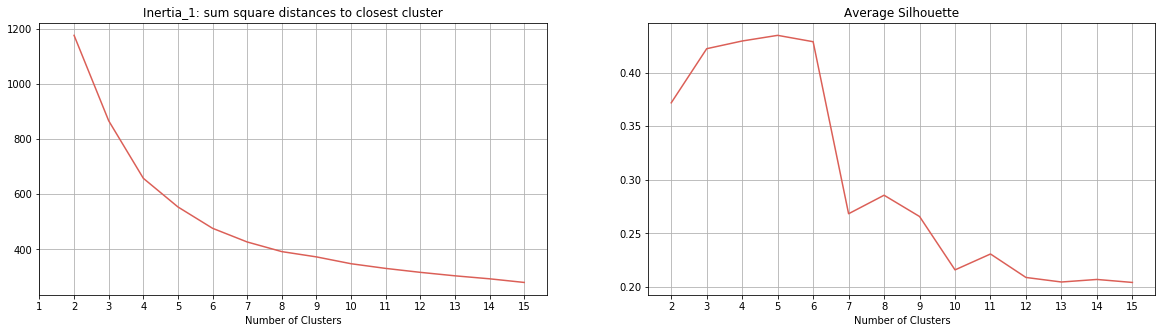

In [28]:
plot_inertias_and_silhouette(X)

Based on the above plots a convenient number of clusters would be probably be 5 or 6.

For these clusters the *inertia* starts to flatten out indicating the sum of the squared distance to the closest cluster isn't getting much better. Also the Silhouette is at it's peak, suggesting that each point is closer to it's current cluster than it is the next closest cluster.

It is difficult to chose between 5 or 6 let's try visualizing the clusters after reducing the dimentionality with:
- TSNE Embedding
- PCA (Principal Component Analysis)
- MDS(Multidimensional Scaling)

### Visualizing 5 Clusters

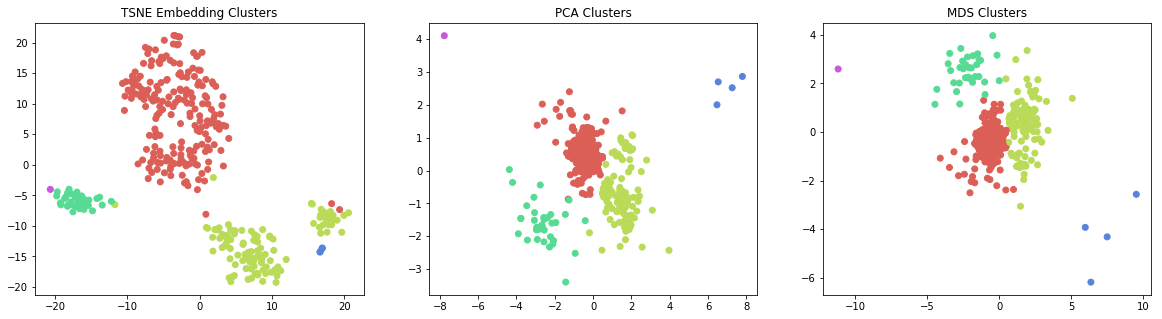

In [29]:
plot_clusters(5, X)

### Visualizing 6 Clusters

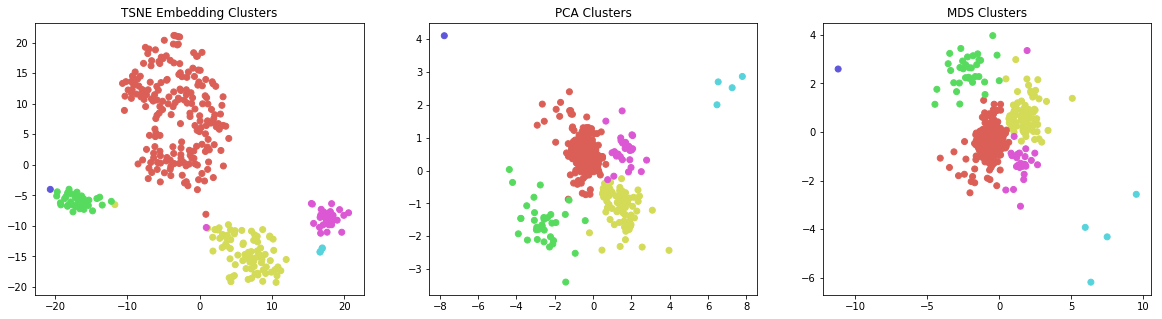

In [30]:
plot_clusters(6, X)

Based on the Inertia/Silhouette and visually examining the clusters in different dimentional spaces, it looks like 6 had slightly better clusters, especially in the TSNE space where it was able to separate the yellow cluster from the fusia cluster.

For our analysis we will go with **6** clusters.

## Part B

In [31]:
kmeans = KMeans(n_clusters=6, random_state=123, n_jobs=-1).fit(X)

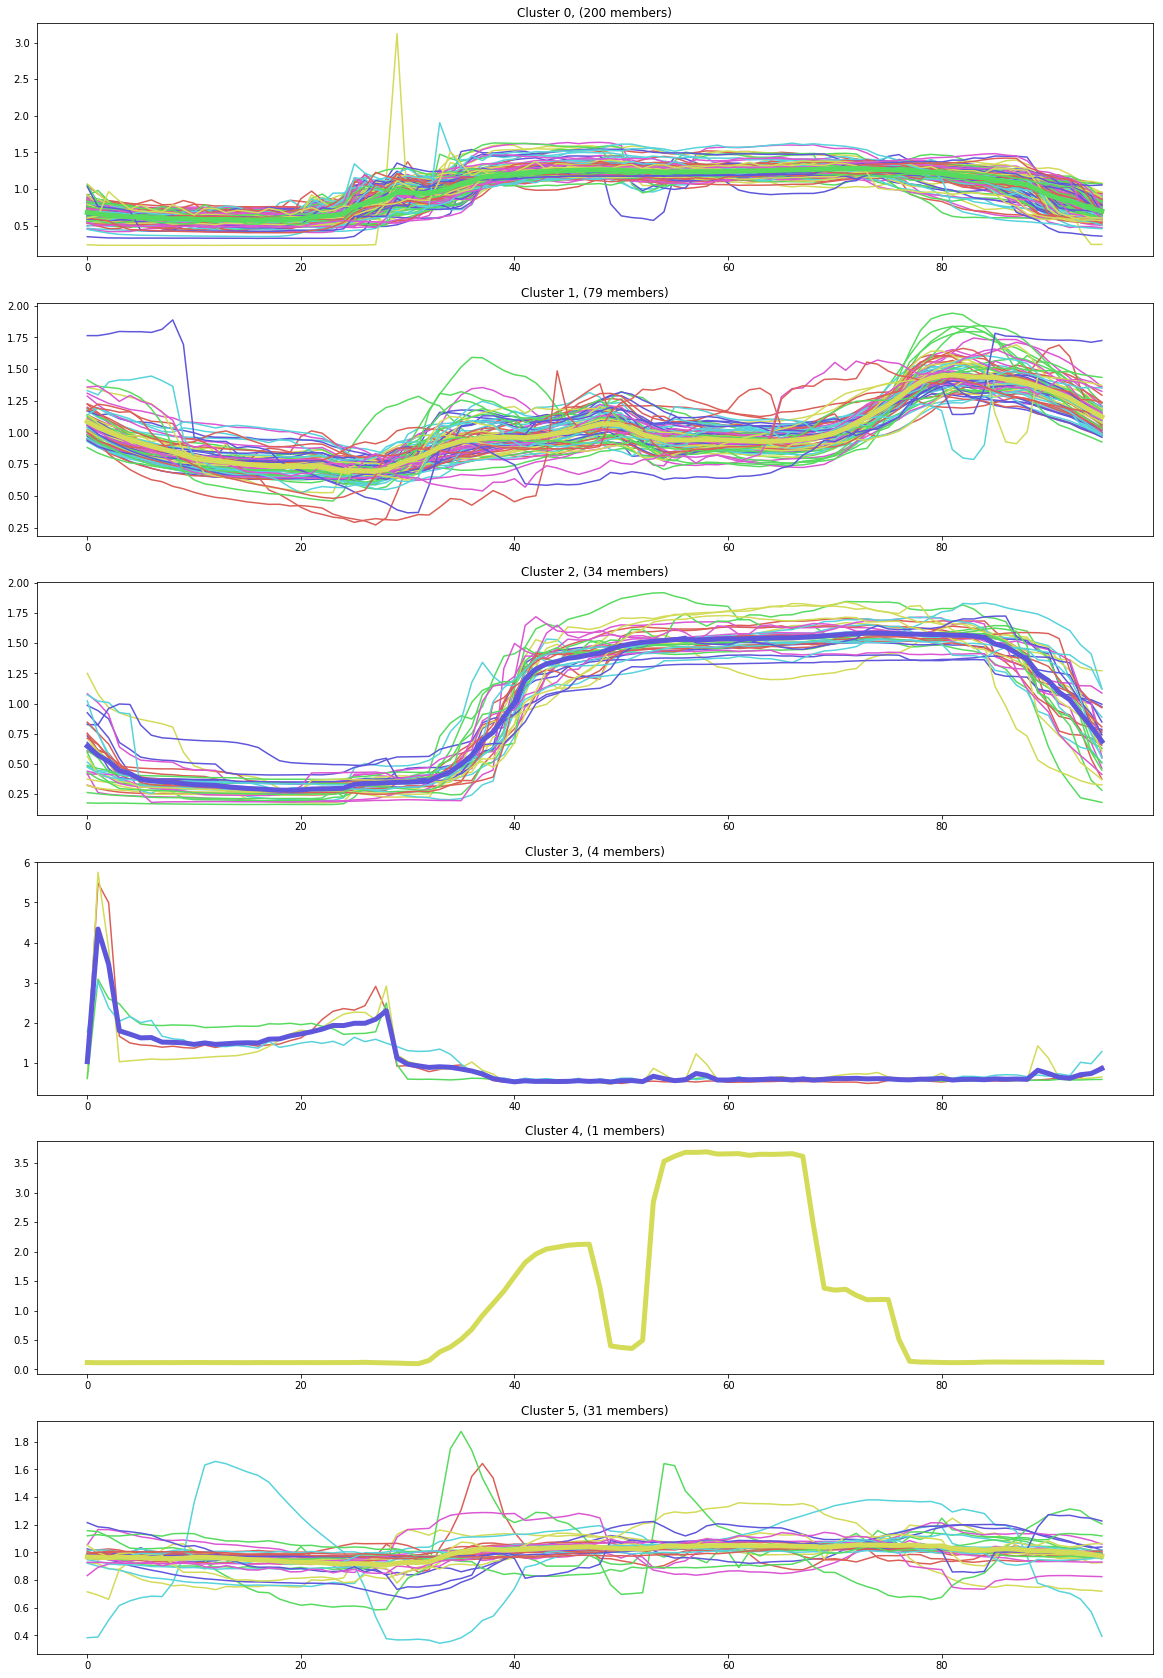

In [32]:
def plot_cluster_points(X, kmeans):
    
    labels = kmeans.labels_
    # Get all the unique cluster labels
    unique_clusters = np.unique(labels)
    centers = kmeans.cluster_centers_
    
    plt.figure(figsize=(20,30))

    for cluster in unique_clusters:
        label_indexes = np.argwhere(labels == cluster)
        if label_indexes.shape[1] != 1:
            label_indexes = np.squeeze(label_indexes)
        clients = X[label_indexes]
        plt.subplot(len(unique_clusters), 1, cluster+1)
        for client in clients:
            plt.plot(range(0, len(client[0])), client[0])

        # Also plot the cluster centers but thicker
        center = centers[cluster]
        plt.plot(range(0, len(center)), center, linewidth=5.0)

        plt.title('Cluster {}, ({} members)'.format(cluster, len(clients)))


    plt.show()
plot_cluster_points(X, kmeans)

### Observations:

**Clusters 0, 1, 2** all seem to have a fairly consistent shape for all the clients in the cluster.

**Cluster 3** contains a few clients that have a similar pattern that varies from the main shape of the rest of the clients.

**Cluster 4** seems to be a single outlier with a more extreme shape than the other clients.

**Cluster 5** seems the least coherent of the clusters and mostly represents clients without a clear trend or a more sporadic trend.

---

## Exercises 2

In this exercise you work with the daily curves of 1 single client.

First you create a list of arrays, each array containing a normalized curve for a day. The list contains 730 arrays, one for each of the days of 2013 and 2014.

a. Determine the optimal value for k-means. 

b. What are the clusters that you obtained represent?

In [33]:
client = 'MT_022'
oneClient = data_13_14[client]
X = [] # a list of arrays, each array being a normalized curve for a day
for J in range(2*365):
    X.extend([np.array(oneClient[J*96:(J+1)*96])])#/np.mean(oneClient[J*96:(J+1)*96])]) 

#### The following cell generates a list of all the days in the two years 2013-2014, which is helpful to answer part (b)

In [34]:
from datetime import date, timedelta

d1 = date(2013, 1, 1)  # start date
d2 = date(2014, 12, 31)  # end date
delta = d2 - d1         # timedelta
daysyear = []
D = {0:'mon', 1:'tue', 2:'wed', 3:'thu', 4:'fri', 5:'sat', 6:'sun'}
for i in range(delta.days + 1):
    daysyear.extend([D[(d1 + timedelta(days=i)).weekday()]+"-"+str(d1 + timedelta(days=i))])

#### The following cell shows you how to do the following: given a list L, and a list of booleans B (True, False), get the sublist of L that corresponds to the True values in B. For example if L=[1,2,3,4] and B=[False,True,True,False], then the results is [2,3]. This is also helpful for pard (b)

In [35]:
from itertools import compress
L = [1,2,3,4]
B = [False, True, True, False]
list(compress(L, B))

[2, 3]

### Part A - Number of Cluster Selection

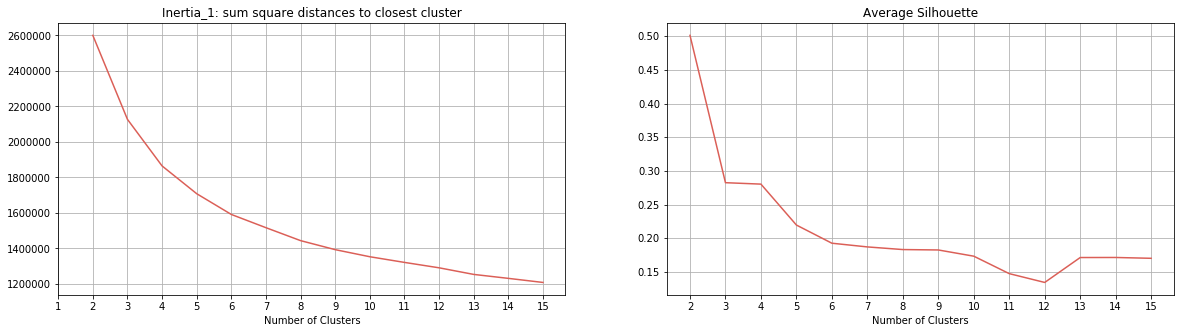

In [36]:
plot_inertias_and_silhouette(X)

A little less clear from the first part. According to the Silhouette plot the best cluster are probably around 3 or 4 but the inertia plot shows the higher clusters are probably a little better.

Let's try examining the clusters in 2D space again

### Visualizing 3 Clusters

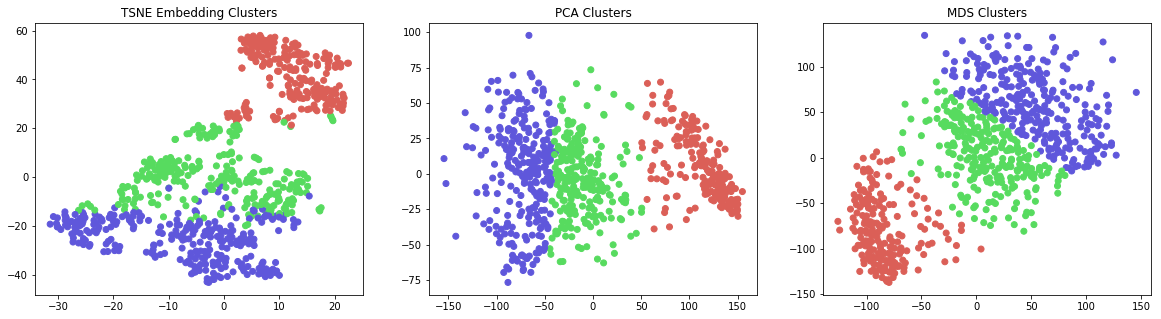

In [37]:
plot_clusters(3, X)

### Viualizing 4 Clusters

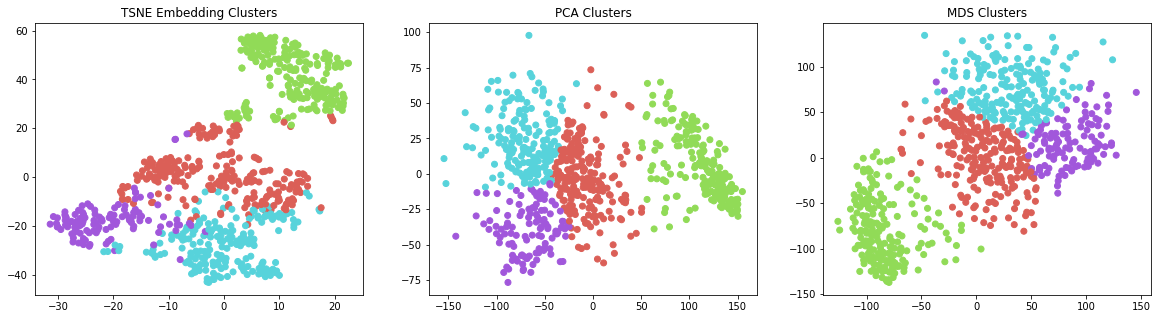

In [38]:
plot_clusters(4, X)

Based on the visualization we will go with **4** clusters but an argument could easily be made for 3.

### Part B - Logical Meaning of the Clusters

In [39]:
num_clusters = 4
kmeans = KMeans(n_clusters=num_clusters, random_state=123, n_jobs=-1).fit(X)

Let's start by visualizing each cluster by looking at the usage over the day.

In [40]:
'''Some common plotting pieces'''

# Set the ticks to have 1 tick per hour
xlocator = matdates.HourLocator(interval = 1)

# Generate a fake time scale of 15 minute intervals for 24 hours
x_dates = [pd.to_datetime(d) for d in np.arange(24*60/15).astype('<i8').view('M8[15m]').tolist()]

# Grab the cluster colors we will use throughout the notebook from seaborn
cluster_colors = sns.color_palette(colormap, num_clusters)

time_formatter = matdates.DateFormatter('%H:%M')

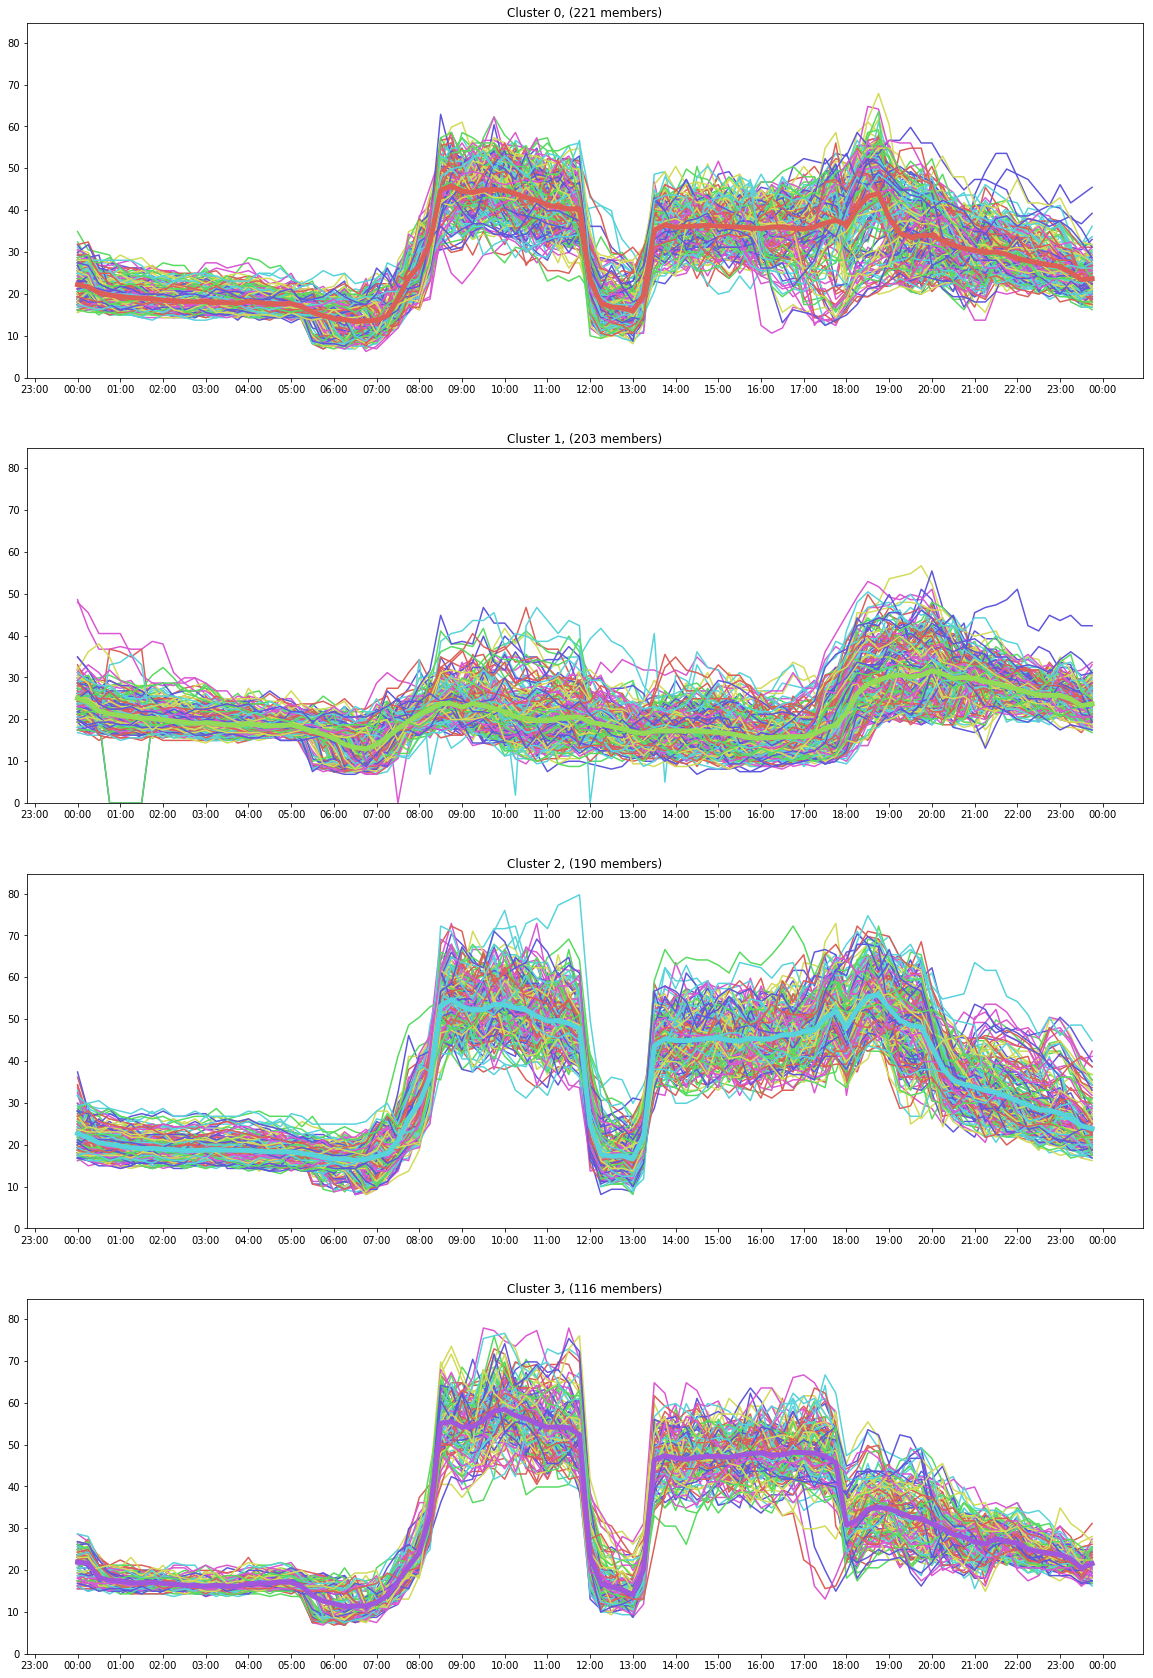

In [41]:
def plot_single_client_clusters(X, kmeans):
    labels = kmeans.labels_
    
    # Get all the unique cluster labels
    unique_clusters = np.unique(labels)
    centers = kmeans.cluster_centers_
    max_entry = np.max(X)
    
    plt.figure(figsize=(20,30))
    
    for cluster in unique_clusters:
        label_indexes = np.squeeze(np.argwhere(labels == cluster))
        days = np.array(X)[label_indexes]
        
        ax = plt.subplot(len(unique_clusters), 1, cluster+1)
        ax.xaxis.set_major_formatter(time_formatter)
        ax.xaxis.set_major_locator(xlocator)
        plt.ylim(0, max_entry + 5)
        for day in days:
            plt.plot(x_dates, day)
            
        # Plot the center of the cluster in a thicker line
        center = centers[cluster]
        plt.plot(x_dates, center, linewidth=5.0, color=cluster_colors[cluster])

        # Print the number of clients in each cluster in the title
        plt.title('Cluster {}, ({} members)'.format(cluster, len(days)))

    plt.show()
plot_single_client_clusters(X, kmeans)

It seems all 4 clusters had a decent % of the data and all have a fairly consistent shape. Let's overlay the centroids so it's easier to compare the clusters.

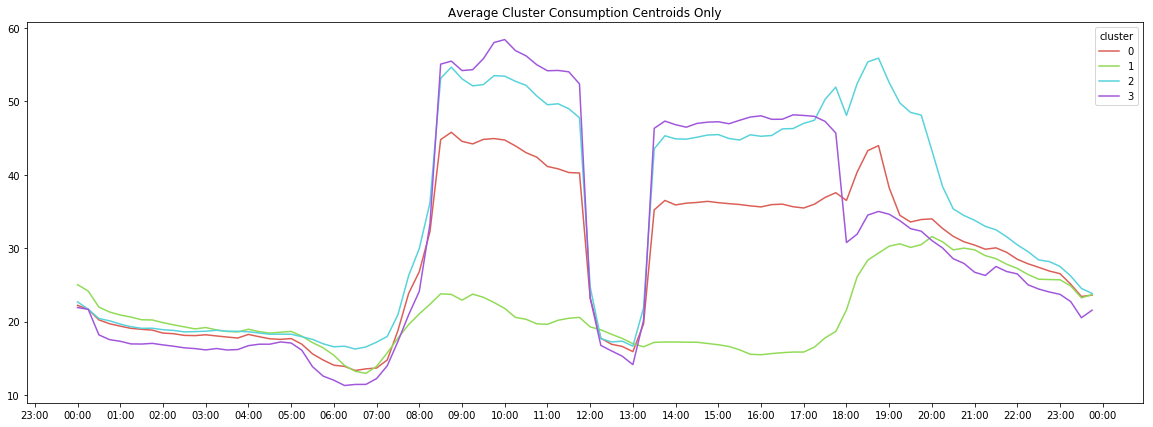

In [42]:
def plot_cluster_centers_together(X, kmeans):
    labels = kmeans.labels_
    
    # Get all the unique cluster labels
    unique_clusters = np.unique(labels)
    centers = kmeans.cluster_centers_
    
    plt.figure(figsize=(20,7))
    ax = plt.subplot(1,1,1)
    ax.xaxis.set_major_formatter(time_formatter)
    ax.xaxis.set_major_locator(xlocator)
    
    for cluster in unique_clusters:              
        # Plot only the center of the cluster
        plt.plot(x_dates, centers[cluster], color=cluster_colors[cluster], label=cluster)

        # Print the number of clients in each cluster in the title
        plt.title('Average Cluster Consumption Centroids Only')
        plt.legend(title="cluster")

    plt.show()
plot_cluster_centers_together(X, kmeans)

#### Observations
While we do see some trend in the daily shape within a cluster it's not as strong as when looking at the cluster of clients.

**Cluster 1** has a more stable usage and on average less usage than the rest of the cluster.

**Cluster 0, 2, and 3** have a similar tend but slight differences.

**Cluster 0** and **Cluster 2** has an extremely similar patterns except **Cluster 0** has an average lower consumption.

**Cluster 3** has the highest usage and dips in the early afternoon instead of immediately spiking like **Cluster 1 and 2**


Next let's visualize the clusters as how they are distributed throughout the 2 years.

We can plot each day along with the average consumption for that day and highlight the day based on which cluster is was placed in.

In [43]:
def plot_individual_time_clusters(ax, dates, X, labels, num_clusters, year, title):
    xlocator = matdates.MonthLocator(interval = 1)
    ax.xaxis.set_major_locator(xlocator)
    ax.xaxis.set_major_formatter(matdates.DateFormatter('%Y-%m'))
    
    dates = [pd.to_datetime(d) for d in dates]
    averages = np.mean(X, axis=1)
    
    plt.scatter(dates, 
                    averages, 
                    s=averages, 
                    c=labels, 
                    label=year, 
                    cmap=ListedColormap(sns.color_palette(colormap, num_clusters)))
    plt.colorbar(ticks=range(num_clusters), label='Cluster')
    plt.clim(-0.5, num_clusters - 0.5)
    plt.legend()
    plt.title('title'.format(year))

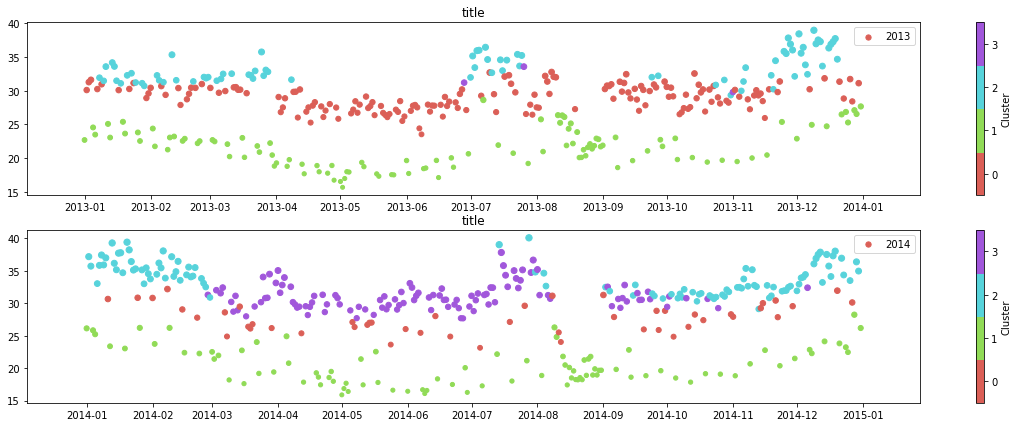

In [44]:
def plot_time_clusters(X, labels):
    plt.figure(figsize=(20,7))
    
    # Split up the data so we can plot 2013 and 2014 separately
    X_splits = np.array_split(X, 2)
    label_splits = np.array_split(labels, 2)
    dates_splits = np.array_split(daysyear, 2)
    years = ['2013', '2014']
    

    num_clusters = len(np.unique(labels))
    
    for i in [0,1]:
        ax = plt.subplot(2,1,i+1)
        plot_individual_time_clusters(ax, 
                                     dates_splits[i],
                                     X_splits[i],
                                     label_splits[i],
                                     num_clusters,
                                     years[i],
                                     'Average Daily Consumption and Cluster Membership for {}')
    plt.show()
    

plot_time_clusters(X, kmeans.labels_)

#### Observations

When we visualize the data over the year we see some potential trends:

**Cluster 1** seems to span evenly throughout the year and is associated with a lower power consumption than the other clusters.

**Cluster 3** seems to appear mostly in Spring to summer of 2014.

**Cluster 2** seems to appear over the winter months of both 2013 and 2014.

Finally **Cluster 0** seems to have less of a trend but it appears far more freqently in 2013 than in 2014.

### Cluster Day/Month/Year Analysis

Next let's look more carefully of which days of the week, which months, and which years are present in each cluster by merging everything into a DataFrame and extracting the particular date elements.

In [45]:
unique_clusters = np.unique(kmeans.labels_)
labels = kmeans.labels_
entries = []
for cluster in unique_clusters:
    label_indexes = np.squeeze(np.argwhere(labels == cluster))
    days_in_cluster = np.array(daysyear)[label_indexes]
    entries_in_cluster = np.array(X)[label_indexes]
    days_in_cluster = [pd.to_datetime(d) for d in days_in_cluster]
    for day, entires in zip(days_in_cluster, entries_in_cluster):
        mean = np.mean(entires)
        std = np.std(entires)
        entries.append([cluster, day, mean, std])
    
cluster_df = pd.DataFrame(entries, columns=['cluster', 'day', 'mean', 'std']) 

In [46]:
cluster_df['day_of_week'] = cluster_df['day'].dt.weekday_name
cluster_df['month'] = cluster_df['day'].dt.month_name()
cluster_df['month_no'] = cluster_df['day'].dt.month
cluster_df['year'] = cluster_df['day'].dt.year

In [47]:
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

In [48]:
cluster_df.head(2)

,cluster,day,mean,std,day_of_week,month,month_no,year
0,0,2013-01-02,30.082503,10.571298,Wednesday,January,1,2013
1,0,2013-01-03,31.250000,11.638351,Thursday,January,1,2013


## Average Cluster Consumption

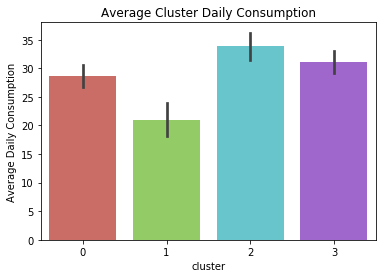

In [49]:
ax = sns.barplot(x="cluster", y='mean', ci='sd', data=cluster_df,  palette=colormap)
ax.set(ylabel='Average Daily Consumption')
ax.set_title('Average Cluster Daily Consumption');

#### Observations

**Cluster 1** had the lowest average consumption while the other 3 clusters which were much closer together.

## Total Cluster Counts

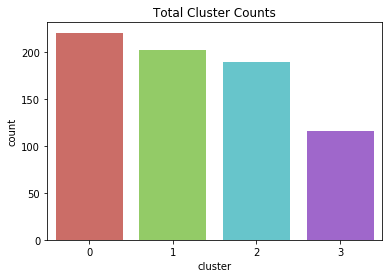

In [50]:
ax = sns.countplot(x="cluster", data=cluster_df, palette=colormap)
ax.set_title('Total Cluster Counts');

#### Observations

For the most part the clusters look even with the exception of **Cluster 3** having about half the number of members as the other clusters.

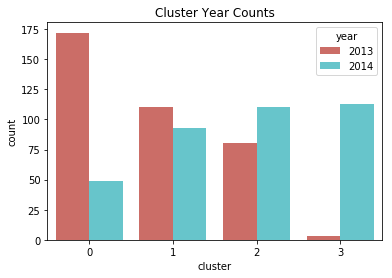

In [51]:
ax = sns.countplot(x="cluster", hue='year', data=cluster_df, palette=colormap)
ax.set_title('Cluster Year Counts');

#### Observations

Again backing up what we saw in the time plot **Cluster 3** seems to mostly consist of  2014 days and **Cluster 0** consists majority of 2013 days with the other cluster being a more balanced mix.

One possible explanation if there was some change in power consumption pattern for 2013 to 2014 the clusters are picking up on.

## Cluster Day of Week Counts

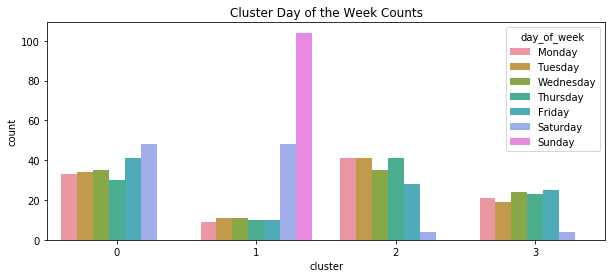

In [52]:
hue_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
fig, ax = plt.subplots(figsize=(10, 4))
sns.countplot(x="cluster", hue='day_of_week', hue_order=hue_order, data=cluster_df, ax=ax)
ax.set_title('Cluster Day of the Week Counts');

### Weekend vs Weekday

It looke like **Cluster 1** may represent weekends so let's compare Sat/Sun vs the other days of the week

In [53]:
day_converter = (lambda x: 'Weekday' if x not in ['Saturday', 'Sunday'] else 'Weekend')
cluster_df['weekend_weekday'] = cluster_df['day_of_week'].apply(day_converter)

In [54]:
cluster_df.head(2)

,cluster,day,mean,std,day_of_week,month,month_no,year,weekend_weekday
0,0,2013-01-02,30.082503,10.571298,Wednesday,January,1,2013,Weekday
1,0,2013-01-03,31.250000,11.638351,Thursday,January,1,2013,Weekday


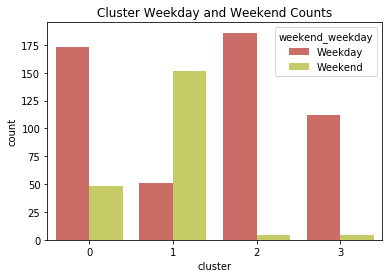

In [55]:
ax = sns.countplot(x="cluster", hue='weekend_weekday', data=cluster_df)
ax.set_title("Cluster Weekday and Weekend Counts");

#### Observations

Interestingly it appears that **Cluster 2 and 3** are entirely made up from weekdays and **Cluster 1** is majority made up of weekends

### Cluster 1 Weekdays

We can dive a little deeper into the weekdays that are in **Cluster 1**. 

In [56]:
weekend_cluster = 1
cluster_1_weekdays = cluster_df[(cluster_df['cluster'] == weekend_cluster) & (cluster_df['weekend_weekday'] == 'Weekday')]

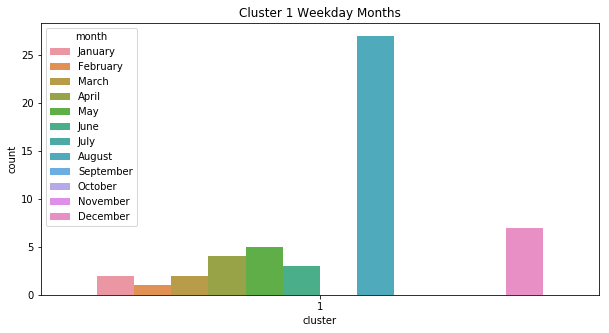

In [57]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.countplot(x="cluster", hue='month', hue_order=months, data=cluster_1_weekdays, ax=ax)
ax.set_title("Cluster 1 Weekday Months");

#### Observation

Interestingly the majority of the **Cluster 1** weekdays are in August and there are no week days in July, September, October, or November.

One possible explanation for the missing months is Portugal is typically a very hot country in the summer with more moderate winters so in the hotter months more air conditioners would be used. In the autumn months heat isn't as necessary as it is in countries like Canada.

The spike in August is the exception here given August is one of the hottest months for the country. If went back to the year plot we see for both 2013 and 2014 there was a drop in average consumption in Augusta and as a result most of these days are placed into **Cluster 1**. One possible explanation for this is people go on vacation during the end of the summer before the school year starts. If we had subject matter experts this may be an interesting phenomenon to dig into.

**WARNING:** The below code requires the *holidays* module installed (not default with Anaconda)

Let's see if the national holidays are also clustered in **Cluster 1**

In [58]:
import holidays
portuguese_holidays = [pd.to_datetime(date) for date, name in holidays.Portugal(years=[2013, 2014]).items()]

cluster_1_days = cluster_df[(cluster_df['cluster'] == weekend_cluster)]['day']
num_holidays_in_cluster_1 = cluster_1_days.isin(portuguese_holidays).sum()

cluster_1_weekday_dates = cluster_1_weekdays['day']
num_weekday_holidays_in_cluster_1 = cluster_1_weekday_dates.isin(portuguese_holidays).sum()

In [59]:
print("Total number of Portugues Holiday in 2013 and 2014: {}".format(len(portuguese_holidays)))
print("Number of holidays that were grouped in Cluster 1: {}".format(num_holidays_in_cluster_1))
print("Number of holiday that on weekdays in Cluster 1: {}".format(num_weekday_holidays_in_cluster_1))

Total number of Portugues Holiday in 2013 and 2014: 18
Number of holidays that were grouped in Cluster 1: 17
Number of holiday that on weekdays in Cluster 1: 14


#### Observations

17/18 holidays in Portual were grouped in **Cluster 1** and 14 of those fell on weekdays.

This makes sense as holiday likely have a similar pattern to weekends

## Cluster 0 Yearly/Weekday/Weekend Breakdown

Let's also take a closer look at **Cluster 0**. This cluster had an interesting phenomenon because it was very prevalent in 2013 but less so in 2014. It also had the highest mixture of both weekend and weekdays.

Let's examine the weekday/weekend for each year individually.

In [60]:
cluster_0 = cluster_df[cluster_df['cluster'] == 0]

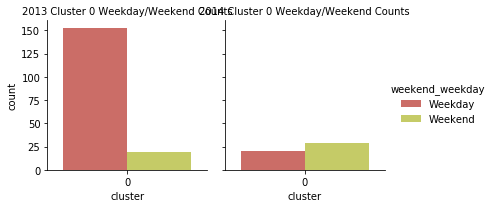

In [61]:
g = sns.catplot(x="cluster", hue="weekend_weekday", col="year",
                 data=cluster_0, kind="count",
                 height=3, aspect=.9);
g.set_titles("{col_name} Cluster 0 Weekday/Weekend Counts");

#### Observations

The weekend day counts stay very consistent but the number of weekday drop significantly in 2014.

## Cluster Month Counts

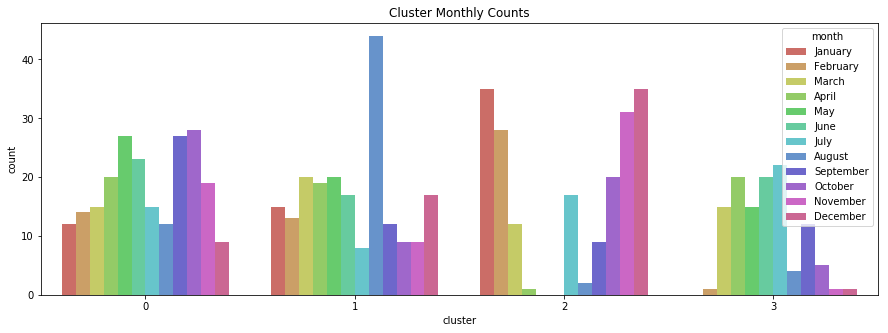

In [62]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.countplot(ax=ax, x="cluster", hue='month', hue_order=months, data=cluster_df, palette=colormap)
ax.set_title('Cluster Monthly Counts');

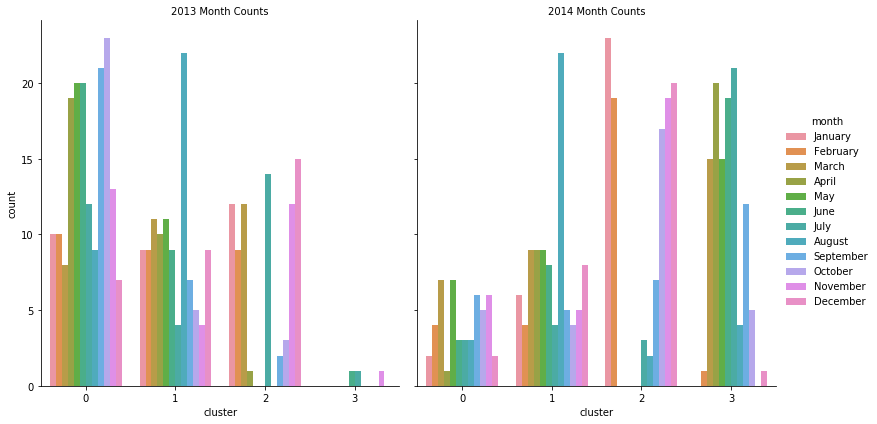

In [63]:
g = sns.catplot(x="cluster", hue="month", col="year", hue_order=months,
                 data=cluster_df, kind="count",
                 height=6, aspect=.9);
g.set_titles("{col_name} Month Counts");

### Seasons

Similar to how we broke the days into weekend/weekdays let's break the months into season so we can check for potential seasonal trends

In [64]:
season_map = {}
season_map[1] = 'Winter'
season_map[2] = 'Winter'
season_map[3] = 'Spring'
season_map[4] = 'Spring'
season_map[5] = 'Spring'
season_map[6] = 'Summer'
season_map[7] = 'Summer'
season_map[8] = 'Summer'
season_map[9] = 'Autumn'
season_map[10] = 'Autumn'
season_map[11] = 'Autumn'
season_map[12] = 'Winter'
cluster_df['season'] = cluster_df['month_no'].map(season_map)
cluster_df.head(2)

,cluster,day,mean,std,day_of_week,month,month_no,year,weekend_weekday,season
0,0,2013-01-02,30.082503,10.571298,Wednesday,January,1,2013,Weekday,Winter
1,0,2013-01-03,31.250000,11.638351,Thursday,January,1,2013,Weekday,Winter


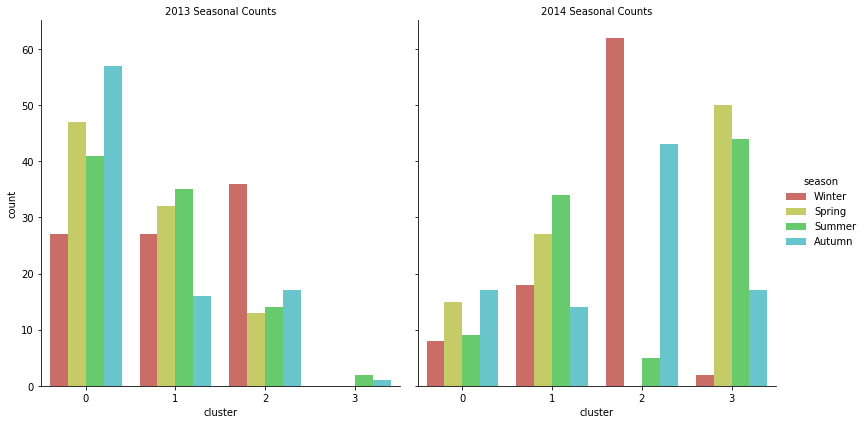

In [65]:
g = sns.catplot(x="cluster", hue="season", col="year",
                 data=cluster_df, kind="count",
                 height=6, aspect=.9);
g.set_titles("{col_name} Seasonal Counts");

#### Observations

**Cluster 0** seems to be more evenly distributed in all 4 months but mostly on in 2013.

**Cluster 1** seems to be evenly distributed throughtout all months and seasons with a peak in Summer.

**Cluster 2** seems to be concentrated on the Winter for 2013/2014 and Autumn in 2014.

**Cluster 3** seems to be concentrated in the summer months of 2014.

# Conclusions


There are some conclusions we can try to draw about the meaning for each of the cluster after looking deeper into the data.

## Cluster 1

**Cluster 1** seems to represent days that have a lower more stable usage and is composed of mostly the weekends and holidays from both years.

An anomaly in this pattern is the a spike in lower usage in August.

## Cluster 2

**Cluster 2** is characterized by a high usage spike in the morning, drop around midday and another spike around the afternoon. The overall power consumption starts dropping off at later in the evening around ~10pm. On average the days in the cluster have the highest average consumption. 

The days in the cluster appear to also be evenly distributed throughout both 2013 and 2014 and by a large margin represented only weekdays. Seasonally this cluster appears more in winter months. The winter months also may explain the later drop off as winter months have less daylight.

A decent summary of this cluster would be weekdays from 2013-2014 in the winter months or week days in other months with higher power consumption.


## Cluster 0

**Cluster 0** has a similar consumption trend to **Cluster 2** but a slightly lower average consumption per day.

Members of **Cluster 0** appear far more frequently in year 2013 compared to 2014 but are present in both. 

In 2013 the members are mostly weekdays with about ~15% being weekends.

In 2014 this shifts with a similar ammount of weekend days but far fewer weekday days. 

**Cluster 0** like **Cluster 1** is also distributed across all 12 months with peaks in the Spring and Autumn.

It's a little difficult to nail down exactly what this cluster represents but there seem to be two possible subgroups to the cluster.

1. Throughout the year for both 2013 and 2014 it seems to represent weekends that have higher than average power consumption so don't fit into **Cluster 1**. 

2. In the Spring and Autumn of 2013 it also represents majority of the workdays. If we look at the average daily consumption over the 2 years plot we see for Spring and Autumn of 2013 there are only **Cluster 1** for the weekends and **Cluster 0** for the weekdays.

## Cluster 3

**Cluster 3** has a pattern that seems to be a hybrid between **Cluster 2** and **Cluster 0** with a difference because around 6pm its consumption drops rather than spiking like the other clusters.

**Cluster 3** had the fewest members and only is seen in 2014. Similar to **Cluster 2** it consists nearly entirely of weekdays.

Monthly/Seasonally it appears reguarly across the Spring to Augumn but drops off entirely in the Winter.

As a summary this cluster appears to be the workdays for 2014 in non-winter months.

There is also the anomaly of the different evening consumption pattern compared to the other clusters.

## Overall Thoughts

- **Cluster 1** had the greatest distinction from the other clusters as it mostly represented low consumption days like weekend/holidays
- **Cluster 2** showed a pretty distinctive pattern for both years as the the winter months
- **Cluster 0** seems to contain 2 distinctive groups (high consumption weekend + 2013 non-winter weekday) which had overlap with **Cluster 2** and **Cluster 3**
- **Cluster 3** seemed to be the 2014 version of **Cluster 0** for non-winter weekdays

### Questions Invoked About Results
- If we had picked _3_ clusters instead of _4_ would **Cluster 3** and **Cluster 0** have been merged into a single cluster that more evenly spanned both years?
- If we had picked _5_ clusters instead of _4_ would the dual groups of **Cluster 0** been separated into a weekend and a weekday group?
- Why are 2013 and 2014 consumption trends so different in the non-winter weekdays months that the algorithm separated into **Cluster 0** and **Cluster 3** but didn't split the weekend days (**Cluster 1**) and winter weekdays (**Cluster 2**)? (Note: If we picked higher number of clusters maybe it would have!).
- Why does **Cluster 3** have a different afternoon behavior than the other *weekday* clusters?
- Why is there an over all decrease power consumption in August both years?